In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git
!pip install tensorflow==1.14
!pip install tensorflow-gpu==1.14


In [ ]:
!pip install keras==2.2.0

In [3]:
!pwd
import os
#Break os and restart
#os._exit(00)

/content


In [4]:
!pwd

/content


In [ ]:
import os
# Go inside MaskRCNN and start install
os.chdir('/content/Mask_RCNN')
!python3 setup.py install

In [6]:
# One step back and start
os.chdir('../')
!pwd

/content


In [14]:
import os
import shutil
import sys
import urllib

import skimage.io
import numpy as np
# Root directory of the project
from Mask_RCNN.mrcnn import utils, config
from mrcnn.config import Config
from Mask_RCNN.mrcnn.visualize import random_colors
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "coco/"))  # To find local version
import coco
import cv2
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import tkinter
import matplotlib



In [15]:

# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']



COCO_MODEL_URL = "https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5"



# Directory to save logs and trained model
MODEL_DIR = os.path.join("logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join("mask_rcnn_coco.h5")

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)



... done downloading pretrained model!


In [45]:
class CustomConfig(coco.CocoConfig):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    # Give the configuration a recognizable name

    def __init__(self, num_classes):
        self.NUM_CLASSES = num_classes
        super().__init__()

    NAME = "headlights"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 300

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5

    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    DETECTION_MIN_CONFIDENCE = 0.85

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50
    POST_NMS_ROIS_INFERENCE = 500
    POST_NMS_ROIS_TRAINING = 1000


In [46]:

class InferenceConfig(CustomConfig):
    def __init__(self, num_classes = 2):
        super().__init__(num_classes = num_classes)

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85

In [27]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """

    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()

        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(
                    class_name))
                return

            self.add_class(source_name, class_id, class_name)

        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)

        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))

                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]

                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )

        # Adding the rest COCO classed
        # for i in range(0,len(class_names)):
        #     self.add_class(class_names[i], i + len(self.class_info), class_names[i])
        #     #i + len(self.class_info) means after adding my class and BackGround Class
        #
        # print("Total Classes: ",len(self.class_info))

    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []

        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)

        return mask, class_ids

In [19]:
def download_trained_weights(coco_model_path, verbose=1):
    if verbose > 0:
        print("Downloading pretrained model to " + coco_model_path + " ...")
    with urllib.request.urlopen(COCO_MODEL_URL) as resp, open(coco_model_path, 'wb') as out:
        shutil.copyfileobj(resp, out)
    if verbose > 0:
        print("... done downloading pretrained model!")

In [30]:
def load_data():

    dataset_train = CocoLikeDataset()
    dataset_train.load_data('train/trainval.json', 'train/images')
    dataset_train.prepare()

    dataset_val = CocoLikeDataset()
    dataset_val.load_data('valid/trainval.json', 'valid/images')
    dataset_val.prepare()

    return dataset_train,dataset_val


In [21]:

def show_data():
    dataset_train,dataset_val = load_data()
    image_ids = np.random.choice(dataset_train.image_ids, 4)
    for image_id in image_ids:
        image = dataset_train.load_image(image_id)
        mask, class_ids = dataset_train.load_mask(image_id)
        visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [22]:
def create_config_load_model():
    config = CustomConfig(num_classes=2)
    config.display()
    model = modellib.MaskRCNN(mode="training", config=config,
                              model_dir=MODEL_DIR)

    # Which weights to start with?
    init_with = "coco"  # imagenet, coco, or last

    if init_with == "imagenet":
        model.load_weights(model.get_imagenet_weights(), by_name=True)
    elif init_with == "coco":
        # Load weights trained on MS COCO, but skip layers that
        # are different due to the different number of classes
        # See README for instructions to download the COCO weights
        model.load_weights(COCO_MODEL_PATH, by_name=True,
                           exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                    "mrcnn_bbox", "mrcnn_mask"])
    elif init_with == "last":
        # Load the last model you trained and continue training
        model.load_weights(model.find_last(), by_name=True)

    return model,config

In [33]:
def train_model():
    model,config = create_config_load_model()
    dataset_train, dataset_val = load_data()

    start_train = time.time()
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=10,
                layers='heads')
    end_train = time.time()
    minutes = round((end_train - start_train) / 60, 2)
    print(f'Training took {minutes} minutes')

    print("Saving model")
    model.keras_model.save_weights('mask_rcnn_headlights.h5')

    return dataset_train

In [24]:
def load_pretrained_model():
    # Directory to save logs and trained model
    MODEL_DIR = os.path.join("logs")
    # Local path to trained weights file
    COCO_MODEL_PATH = os.path.join("mask_rcnn_headlights.h5")


    config = InferenceConfig(num_classes = 2)
    config.display()
    # Create model object in inference mode.
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
    # Load weights trained on MS-COCO
    model.load_weights(COCO_MODEL_PATH, by_name=True)
    return model

In [25]:
def predict_static_image(image_name):
    model = load_pretrained_model()
    dataset_train,dataset_valid  = load_data()

    file_name = image_name
    image = skimage.io.imread(file_name)
    # Run detection
    results = model.detect([image], verbose=1)

    # Visualize results
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                                dataset_train.class_names, r['scores'])


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.1
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

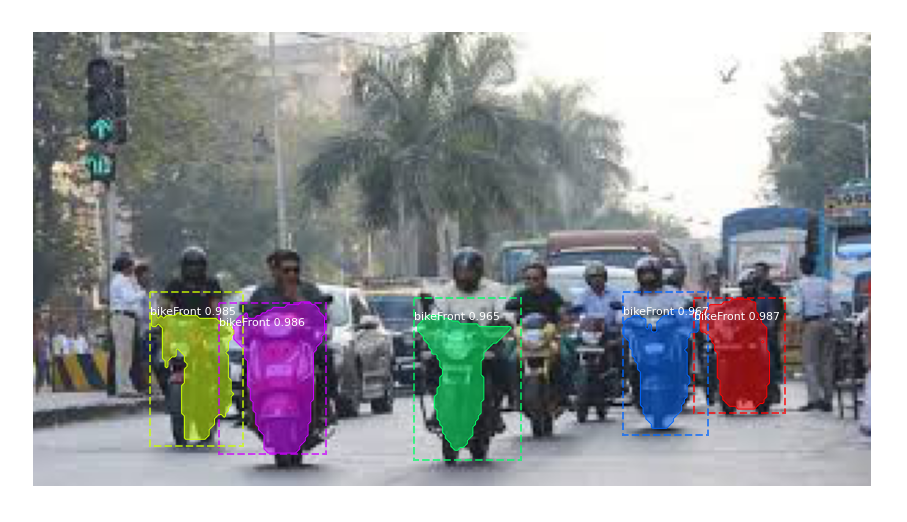

In [47]:
# show_data()

# dataset_train = train_model()
# print("Dataset Class Names")
# print(dataset_train.class_names)

predict_static_image("test/test5.jpg")
